In [1]:
import logging
import json
import os
import re
from typing import Optional, List

import scanpy as sc 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import wandb
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, BatchSampler
from torchvision.transforms import ColorJitter, Normalize, RandomHorizontalFlip, RandomVerticalFlip, RandomAdjustSharpness
from timm import create_model
from einops import rearrange, reduce
from skimage.color import label2rgb
from skimage.measure import regionprops_table

In [2]:
wandb.login() 

wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


True

#### load annotations

In [3]:
a = sc.read_h5ad('../data/pdac/HT270P1-S1H1U1/adata.h5ad')
a

AnnData object with n_obs × n_vars = 3940 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters', 'spot_index'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'full_res_he', 'hvg', 'leiden', 'log1p', 'neighbors', 'nuclei_segmentation_1X_notrim', 'nuclei_segmentation_1X_trimmed', 'pca', 'rescaled_he', 'rescaled_spot_masks', 'rescaled_spot_metadata', 'segmented_nuclei_coords', 'segmented_nuclei_coords_1X_notrim', 'spatial', 'trimmed', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_16X_notrim', 'spatial_16X_trimmed', 'spatial_1X_notrim', 'spatial_1X_trimmed', 'spatial_2X_notrim', 'spatial_2X_trimmed', 'spatial_4X_notrim', 'spatial_4X_trimmed', 'spatial_8X_notrim', 'spatial_8X_trimmed', 'spatial_trimmed'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

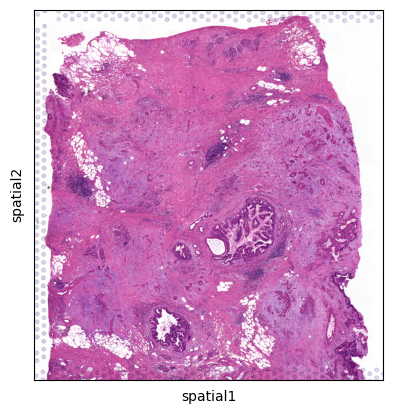

In [5]:
sc.pl.spatial(a)

In [10]:
ls = json.load(open('../data/annotations/pdac/HT270P1-S1H1U1_annotations.geojson'))['features']
label_to_pts = {}
for d in ls:
    coords = d['geometry']['coordinates']
    label = d['properties']['classification']['name']
    label_to_pts[label] = np.asarray(coords, dtype=np.int32)
label_to_pts

{'Epithelial': array([[ 9867, 12441],
        [ 9847, 12429],
        [ 9852, 12492],
        [ 9773, 12498],
        [ 9761, 12582],
        [ 9654, 12156],
        [ 9677, 12164],
        [ 9770, 12193],
        [10083, 12422],
        [10307, 11891],
        [10284, 11972],
        [10329, 11806],
        [10405, 11841],
        [11569, 10927],
        [11449, 11089],
        [11389, 11026],
        [11371, 11008],
        [11366, 10985],
        [12038, 11093],
        [12237, 11661],
        [12254, 11552],
        [12013, 11549],
        [11988, 11656],
        [12027, 11577],
        [11866, 12347],
        [11896, 12365],
        [11930, 12358],
        [11953, 12342],
        [11440, 12757],
        [11236, 12717],
        [11383, 12666],
        [10842, 12796],
        [10849, 12824],
        [10469, 12437],
        [ 6862, 17090],
        [ 7097, 17093],
        [ 7037, 17119],
        [ 6914, 17072],
        [ 6677, 16890],
        [ 6423, 16854],
        [ 6432, 16883],
  

#### make dataloaders

In [ ]:
def get_tile(img, r, c, tile_size=64):
    r1 = r - tile_size // 2
    r2 = r1 + tile_size
    c1 = c - tile_size // 2
    c2 = c1 + tile_size
    
    return img[:, r1:r2, c1:c2]
    
class MergedDataset(Dataset):
    def __init__(self, he, exp, nuclei_coords, he_transform=None, exp_transform=None, labels=None):
        super().__init__()
        self.he = he
        self.exp = exp
        self.coords = nuclei_coords
        
        self.he_transform = nn.Identity() if he_transform is None else he_transform
        self.exp_transform = nn.Identity() if exp_transform is None else exp_transform
        
        if self.labels is not None:
            self.labels = F.one_hot(labels)
        else:
            self.labels = None

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        
        r, c = self.coords[idx]
        he_tile = get_tile(self.he, r, c)
        exp_tile = get_tile(self.he, r, c)

        return {
            'he': self.he_transform(he_tile),
            'exp': self.exp_transform(exp_tile),
            'label': 0 if self.labels is None else self.labels[idx]
        }